In [1]:
import glob
import numpy
import pandas
import seaborn
import matplotlib.pyplot as plt
from tqdm import tqdm
import multiprocessing as mp
import os
from build import build_model

## Experiment Metadata

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
run_data = pandas.read_csv("./ibdmdb/SraRunTable.csv").set_index("host_subject_id")
metadata = pandas.read_csv("./ibdmdb/hmp2_metadata_2018-08-20.csv").set_index("site_sub_coll")

/tmp/ipykernel_3364552/893637399.py:2: DtypeWarning: Columns (12,13,14,40,46,55,65,66,67,68,177,294,298,299,300,301,304,305,306,307,308,309,310,318,320,328,330,346,348,350,352,354,359,361,363,366,373,377,381,383,418,419,432,433,434,435,436,438,439,440,441,442,444,445,446,447,448,450,451,452,453,454) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pandas.read_csv("./ibdmdb/hmp2_metadata_2018-08-20.csv").set_index("site_sub_coll")


In [4]:
metaT_runs = run_data[run_data["LibrarySource"] == "METATRANSCRIPTOMIC"]["Run"]
metaG_runs = run_data[run_data["LibrarySource"] == "METAGENOMIC"]["Run"]
samples = [i.split("_MTX")[0] for i in metaT_runs.index]
subjects = metadata.loc[samples]
diagnosis = metadata.loc[samples][["diagnosis","Participant ID"]].drop_duplicates().set_index("Participant ID")["diagnosis"].sort_values()
# diagnosis = metadata.loc[samples][["diagnosis"]].reset_index().drop_duplicates().set_index("site_sub_coll")["diagnosis"]

In [5]:
ProcessedMetadata = metadata.loc[samples][["diagnosis","Participant ID"]]
ProcessedMetadata["metaT_run"] = [metaT_runs[i+"_MTX"] for i in ProcessedMetadata.index]
ProcessedMetadata["metaG_run"] = [metaG_runs[i+"_MGX"] for i in ProcessedMetadata.index]
ProcessedMetadata.head()

,diagnosis,Participant ID,metaT_run,metaG_run
site_sub_coll,,,,
H4009C2,nonIBD,H4009,SRR5947895,SRR5947845
H4009C2,nonIBD,H4009,SRR5947895,SRR5947845
H4009C2,nonIBD,H4009,SRR5947895,SRR5947845
H4010C1,UC,H4010,SRR5947896,SRR5947846
H4010C1,UC,H4010,SRR5947896,SRR5947846


In [12]:
len(ProcessedMetadata["Participant ID"].unique())

28

In [23]:
ProcessedMetadata.reset_index().groupby("site_sub_coll")["diagnosis"].unique().value_counts()

[CD]        46
[UC]        21
[nonIBD]    11
Name: diagnosis, dtype: int64

In [10]:
ProcessedMetadata.to_csv("ibdmdb/processed_metadata.csv")

## metaG

In [8]:
id_to_name = pandas.read_csv("taxonomy.txt",index_col=1,sep="\t")["MicrobeID"]

In [21]:
metaG = pandas.read_csv("./ibdmdb/metaG_aligned/samfiles/Custom_index_counts.tsv", sep ='\t',index_col=0)
metaG.columns = [i.split("_")[0] for i in metaG.columns]
metaG.index = [id_to_name[i] for i in metaG.index]

In [22]:
RelativeAbundances = metaG.div(metaG.sum())

In [23]:
MeanAbundances = pandas.DataFrame()
SDevAbundances = pandas.DataFrame()
for d in ProcessedMetadata["diagnosis"].unique():
    tmp = RelativeAbundances[ProcessedMetadata[ProcessedMetadata["diagnosis"]==d]["metaG_run"].values]
    MeanAbundances[d] = tmp.mean(axis=1).sort_values(ascending=False)
    SDevAbundances[d] = tmp.std(axis=1).sort_values(ascending=False)
tmp = RelativeAbundances[ProcessedMetadata[ProcessedMetadata["diagnosis"]!="nonIBD"]["metaG_run"].values]
MeanAbundances["IBD"] = tmp.mean(axis=1).sort_values(ascending=False)
SDevAbundances["IBD"] = tmp.std(axis=1).sort_values(ascending=False)
MeanAbundances.head()

,nonIBD,UC,CD,IBD
Bacteroides_vulgatus_ATCC_8482,0.099031,0.086618,0.072900,0.077134
Prevotella_copri_CB7_DSM_18205,0.084706,0.000448,0.129253,0.089498
Faecalibacterium_cf_prausnitzii_KLE1255,0.083950,0.027540,0.042626,0.037970
Bacteroides_sp_3_1_40A,0.076654,0.063514,0.058648,0.060150
Bacteroides_sp_4_3_47FAA,0.074558,0.062121,0.057815,0.059144


<Axes: ylabel='Frequency'>

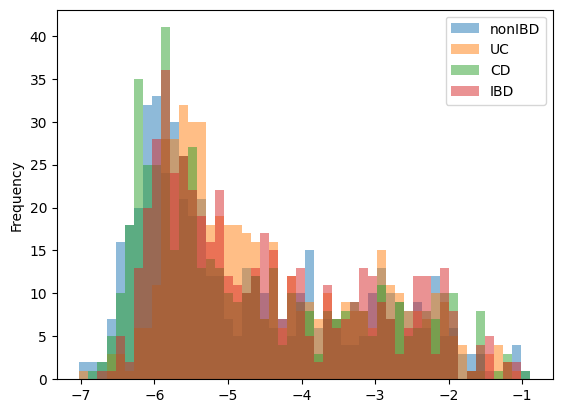

In [24]:
numpy.log10(MeanAbundances).plot.hist(bins = 50,alpha=0.5)

In [25]:
MeanAbundances.to_csv("ibdmdb/metaG_per_diagnosis.csv")

<ErrorbarContainer object of 3 artists>

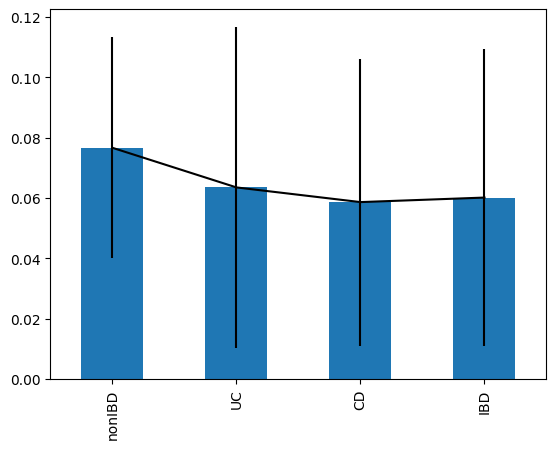

In [26]:
org = "Bacteroides_sp_3_1_40A"
fig,ax = plt.subplots(1,1)
MeanAbundances.loc[org].plot.bar(ax=ax)
ax.errorbar(x=MeanAbundances.columns,y=MeanAbundances.loc[org],color="black",yerr=SDevAbundances.loc[org])

## metaT

In [20]:
metaT = pandas.read_csv("./ibdmdb/metaT_aligned/samfiles/Custom_index_counts.tsv", sep ='\t',index_col=0)
metaT.columns = [i.split("_")[0] for i in metaT.columns]

In [24]:
MeanTCounts = pandas.DataFrame()
for d in ProcessedMetadata["diagnosis"].unique():
    tmp = metaT[ProcessedMetadata[ProcessedMetadata["diagnosis"]==d]["metaT_run"].values]
    MeanTCounts[d] = tmp.mean(axis=1).sort_values(ascending=False)
tmp = metaT[ProcessedMetadata[ProcessedMetadata["diagnosis"]==d]["metaT_run"].values]
MeanTCounts["IBD"] = tmp.mean(axis=1).sort_values(ascending=False)
MeanTCounts.head()

,nonIBD,UC,CD,IBD
#FeatureID,,,,
HMPREF9436_RS14285,540596.974359,274939.333333,346588.291667,346588.291667
HMPREF9436_RS14685,162813.974359,61457.386667,124344.470238,124344.470238
BILO145876EF_RS04385,154947.128205,24252.120000,52853.702381,52853.702381
FAEPRAM212_RS14865,118711.871795,163130.413333,282523.220238,282523.220238
BSFG_RS23450,73381.256410,81992.613333,94516.827381,94516.827381


In [25]:
MeanTCounts.to_csv("ibdmdb/metaT_per_diagnosis.csv")

In [26]:
NormalizedTCounts = MeanTCounts.div(MeanTCounts.sum()) + 1e-10

<Axes: ylabel='Frequency'>

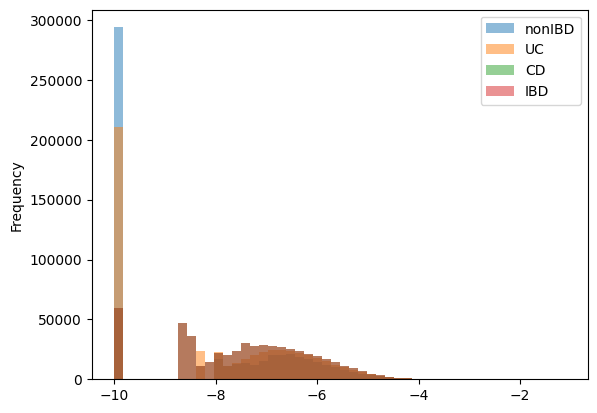

In [27]:
numpy.log10(NormalizedTCounts).plot.hist(bins = 50,alpha=0.5)